In [1]:
import numpy as np
import pandas as pd

from PIL import Image
from io import BytesIO
import base64

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.dummy import DummyRegressor

import pickle

In [2]:
train = pd.read_csv("train.csv")

In [3]:
train["text"] = train["text"].fillna("")

In [4]:
train.loc[12345].text

'наш слоняра &#128170;'

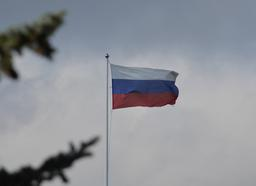

In [5]:
Image.open(BytesIO(base64.b64decode(train.loc[12367].photo)))

In [6]:
text_vectorizer = CountVectorizer(max_features=512)

In [7]:
def img_vectorizer(photo_base64):        
    img = np.array(Image.open(BytesIO(base64.b64decode(photo_base64))))    
    
    s = img.shape
    if (len(s) == 2):
        img = np.repeat(img, 3)
        
    h, w = s[0], s[1]
    img.resize((h * w, 3))    
    
    stats = []
    stats.append(np.array([h,w]))
    stats.append(img.min(axis=0))
    stats.append(img.max(axis=0))
    stats.append(img.mean(axis=0))
    stats.append(img.std(axis=0))
    stats.append(np.median(img, axis=0))
    cm = np.corrcoef(img.T)
    stats.append(cm[np.triu_indices(len(cm), k = 1)])
    return np.concatenate(stats) 

In [8]:
X_img = np.vstack(train['photo'].map(img_vectorizer))

In [9]:
X_text = text_vectorizer.fit_transform(train['text']).toarray()

In [10]:
X = np.hstack([X_text, X_img])

In [11]:
with open('text_vectorizer.pickle', 'wb') as f:
    pickle.dump(text_vectorizer, f)

In [12]:
target = ["like", "comment", "hide", "expand", "open_photo", "open", "share_to_message"]

In [13]:
model = {}
for column in target:
    reg = DummyRegressor()
    y = train[column]/train['view']
    reg.fit(X, y)
    model[column] = reg
    print(column)

like
comment
hide
expand
open_photo
open
share_to_message


In [14]:
with open('model.pickle', 'wb') as f:
    pickle.dump(model, f)